<a href="https://colab.research.google.com/github/junaaidjabbar/Assignment-Week-4/blob/main/Agent_for_CreditCard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
!pip install -q langchain_google_genai langchain_core langchain_community tavily-python langgraph

In [36]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage, ToolMessage, AIMessage
from langchain_core.messages import BaseMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from pydantic import BaseModel

import os

In [37]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

import os
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')

In [38]:
import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

In [39]:
class State(TypedDict):
  messages: Annotated[list, add_messages]
  human: bool

In [40]:
class RequestAssistant(BaseModel):
  """Escalate the conversation to an expert. Use this if you are unable to assist directly or
  if the user requires support beyond your permissions"""
  request: str

In [42]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model = "gemini-1.5-flash",
    max_retries=2,
    api_key = GEMINI_API_KEY
)

In [43]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools + [RequestAssistant])

In [44]:
def chatbot(state: State):
  prompt = """
      You are a knowledgeable and helpful credit card service agent for Bank Alfalah. For more information other than credit card you simply referred to customer our website https://www.bankalfalah.com

      Here are the types of credit cards we offer:

      * Bank Alfalah Mastercard: A versatile card for everyday spending.
      * Optimus Credit Card: A premium card with exclusive benefits and rewards.
      * Bank Alfalah VISA Platinum Credit Card: A prestigious card offering global acceptance and luxury perks.
      * Bank Alfalah VISA Gold Credit Card: A balanced card with solid rewards and benefits.
      * Bank Alfalah VISA Classic Credit Card: A basic card for essential spending.
      * Bank Alfalah American Express Card: A globally recognized card with unique privileges.
      * Bank Alfalah Ultra Cashback Card: A rewarding card that offers cashback on every purchase.
      * Bank Alfalah VISA Corporate Card: A business card designed for corporate expenses.

      Key Features and Benefits of Bank Alfalah Credit Cards:

      * Global Reach and Acceptability: Use your card worldwide.
      * Exclusive Discounts: Enjoy special offers at various merchants.
      * Fabulous Rewards: Earn points on every purchase and redeem them for exciting rewards.
      * SBS Instalment Plans: Break down large purchases into easy monthly installments.
      * Cash Advance: Access cash when you need it.
      * Balance Transfer Facility: Consolidate your debts into one easy payment.
      * Zero Loss Liability: Stay protected against unauthorized transactions.
      * Revolving Credit: Enjoy flexible payment options.
      * Supplementary Cards: Add authorized users to your account.
      * 24-Hour Customer Service: Assistance is just a call away.
      * Bank Alfalah Tap & Pay: Convenient and secure contactless payments.

      How can I assist you today? Please feel free to ask any questions about our credit cards, their features, benefits, or how to apply.

      If you'd like to explore further details and apply online, you can visit the Bank Alfalah website: https://www.bankalfalah.com/personal-banking/cards/credit-cards
  """

  messages = [HumanMessage(content=prompt)] + state["messages"]

  response = llm_with_tools.invoke(messages)
  ask_human = False
  if response.tool_calls and response.tool_calls[0]["name"] == RequestAssistant.__name__:
    ask_human = True
  return {"messages": [response], "ask_human": ask_human}

In [61]:
def create_response(response: str, ai_message: AIMessage):
  return ToolMessage(
      content=response,
      tool_call_id=ai_message.tool_calls[0]["id"]
  )

def human_node(state: State):
  new_messages = []
  if not isinstance(state["messages"][-1], ToolMessage):
    new_messages.append(
        create_response("No response from humans.", state["messages"][-1])
    )
  return {
      "messages": new_messages,
      "ask_human": False,
  }


In [62]:
def select_next_node(state: State):
  if state["ask_human"]:
    return "humans"
  return tools_condition(state)

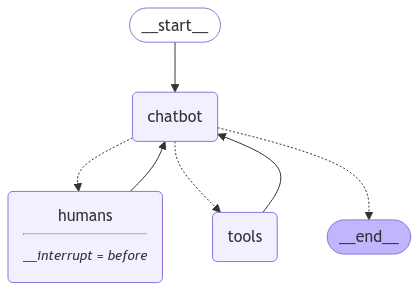

In [63]:
graph_builder = StateGraph(State)

## Nodes

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))
graph_builder.add_node("humans", human_node)

## Edges

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("humans", "chatbot")

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"humans": "humans" , "tools" : "tools", END : END},
)

memory = MemorySaver()

graph = graph_builder.compile(checkpointer = memory, interrupt_before = ["humans"])

from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass


In [65]:
user_input = "I want to know about Bank Alfalah Gold credit card."
config = {"configurable" : {"thread_id" : "1"}}

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode = "values"
)
for event in events:
  if "messages" in event:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I want to know about Bank Alfalah Gold credit card.
================================== Ai Message ==================================

The Bank Alfalah VISA Gold Credit Card offers a balance of rewards and benefits.  While I don't have the exact details on current interest rates, fees, or specific reward programs (those details change), it generally provides solid rewards for your spending and is widely accepted globally.  Key features likely include:

* **Global Acceptance:** Use your card for purchases worldwide.
* **Rewards Program:** Earn points or cashback on purchases (the specifics would be on the Bank Alfalah website).
* **Other Benefits:**  May include things like purchase protection, travel insurance (check the website for current offerings).

For the most up-to-date information on interest rates, fees, rewards programs, and application details, please visit the Bank Alfalah website: https://www.